In [1]:

#imports
from sqlalchemy import create_engine
from datetime import timedelta, datetime, tzinfo
from zipfile import ZipFile
import collections
import pandas as pd

In [2]:
#read in csvs
states_df = pd.read_csv("all-states-history.csv")

national_df = pd.read_csv("national-history.csv")

In [3]:
states_df.head(10)

,date,state,death,deathConfirmed,deathIncrease,hospitalized,hospitalizedCurrently,positive,positiveIncrease,recovered,totalTestResults,totalTestResultsIncrease
0,3/7/21,AK,305.0,NaN,0,1293.0,33.0,56886.0,0,NaN,1731628.0,0
1,3/7/21,AL,10148.0,7963.0,-1,45976.0,494.0,499819.0,408,295690.0,2323788.0,2347
2,3/7/21,AR,5319.0,4308.0,22,14926.0,335.0,324818.0,165,315517.0,2736442.0,3380
3,3/7/21,AS,0.0,NaN,0,NaN,NaN,0.0,0,NaN,2140.0,0
4,3/7/21,AZ,16328.0,14403.0,5,57907.0,963.0,826454.0,1335,NaN,7908105.0,45110
5,3/7/21,CA,54124.0,NaN,258,NaN,4291.0,3501394.0,3816,NaN,49646014.0,133186
6,3/7/21,CO,5989.0,5251.0,3,23904.0,326.0,436602.0,840,NaN,6415123.0,38163
7,3/7/21,CT,7704.0,6327.0,0,12257.0,428.0,285330.0,0,NaN,6520366.0,0
8,3/7/21,DC,1030.0,NaN,0,NaN,150.0,41419.0,146,29570.0,1261363.0,5726
9,3/7/21,DE,1473.0,1337.0,9,NaN,104.0,88354.0,215,NaN,1431942.0,5867


In [4]:
national_df.head()

,date,death,deathIncrease,hospitalizedIncrease,hospitalizedCurrently,hospitalizedCumulative,negative,negativeIncrease,positive,positiveIncrease,totalTestResults,totalTestResultsIncrease
0,3/7/21,515148.0,839,726,40212.0,878613.0,74582825.0,131835,28756184.0,41530,363824818,1169754
1,3/6/21,514309.0,1680,503,41401.0,877887.0,74450990.0,143835,28714654.0,60015,362655064,1430992
2,3/5/21,512629.0,2221,2781,42541.0,877384.0,74307155.0,271917,28654639.0,68787,361224072,1744417
3,3/4/21,510408.0,1743,1530,44172.0,874603.0,74035238.0,177957,28585852.0,65487,359479655,1590984
4,3/3/21,508665.0,2449,2172,45462.0,873073.0,73857281.0,267001,28520365.0,66836,357888671,1406795


KeyError: 'date'

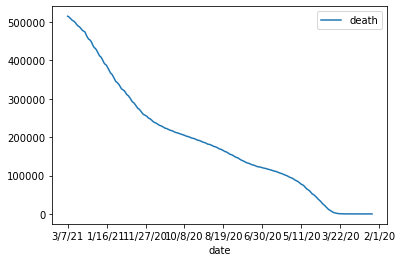

In [5]:
death = national_df.plot.line(x='date', y='death')

#we can loc for the past 3 months
date_df = national_df.set_index("date")
date_df.sort_values(by=['date'], inplace=True, ascending=False)
monthtrend_df = date_df.loc['01/01/21':'3/7/21']

trend=monthtrend_df.plot.line(x='date', y='death')


In [ ]:
positive=national_df.plot.line(x='date', y='positive')

In [13]:
connection_string = "postgres:Sparty17@localhost:5432/Covid"
engine = create_engine(f'postgresql://{connection_string}')

In [14]:
engine.table_names()

OperationalError: (psycopg2.OperationalError) FATAL:  password authentication failed for user "postgres"

(Background on this error at: http://sqlalche.me/e/13/e3q8)

In [33]:
michigan_df = states_df.loc[states_df['state'] == "MI", :]

michigan_df

,date,state,death,deathConfirmed,deathIncrease,hospitalized,hospitalizedCurrently,positive,positiveIncrease,recovered,totalTestResults,totalTestResultsIncrease
24,3/7/21,MI,16658.0,15666.0,0,NaN,866.0,656072.0,0,549881.0,10621967.0,0
80,3/6/21,MI,16658.0,15666.0,57,NaN,866.0,656072.0,1692,549881.0,10621967.0,37232
136,3/5/21,MI,16601.0,15610.0,12,NaN,866.0,654380.0,1791,541258.0,10584735.0,46112
192,3/4/21,MI,16589.0,15600.0,39,NaN,890.0,652589.0,1827,541258.0,10538623.0,46486
248,3/3/21,MI,16550.0,15563.0,6,NaN,882.0,650762.0,1705,541258.0,10492137.0,36453
...,...,...,...,...,...,...,...,...,...,...,...,...
20503,3/5/20,MI,NaN,0.0,0,NaN,NaN,100.0,26,NaN,NaN,0
20533,3/4/20,MI,NaN,0.0,0,NaN,NaN,74.0,24,NaN,NaN,0
20553,3/3/20,MI,NaN,NaN,0,NaN,NaN,50.0,23,NaN,NaN,0
20569,3/2/20,MI,NaN,NaN,0,NaN,NaN,27.0,13,NaN,NaN,0


In [34]:
michigan_df.to_csv("michigan-data.csv")

In [18]:
import psycopg2
import pandas as pd
import os
from io import StringIO
import sys

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
param_dic = {
    "host"      : "localhost",
    "database"  : "Covid19_Project2",
    "user"      : "postgres",
    "password"  : "Osram919267%"
}
db_url = {'drivername': 'postgresql+psycopg2',
        'username': 'postgres',
        'password': 'Osram919267%',
        'host': 'localhost',
        'port': 5432,
        'database': 'Covid19_Project2'
}
def connect(params_dic):
    '''Connect to the PostgreSQL database server'''
    conn = None
    try:
        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(**params_dic)
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        print("Connection not successful!")
        sys.exit(1)
    print("Connection Successful!")
    return conn
def execute_query(conn, query):
    """ Execute a single query """
    ret = 0 # Return value
    cursor = conn.cursor()
    try:
        cursor.execute(query)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    # If this was a select query, return the result
    if 'select' in query.lower():
        ret = cursor.fetchall()
    cursor.close()
    return ret
def open_as_df(query,conn):
    '''pass query to get dataframe: select * from "5_min" '''
    try:
        df = pd.read_sql_query(sql = query,con = conn, index_col= ['date'])
        df = df.tz_localize('EST', level = 'time')
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        sys.exit(1)
    conn.close()
    return df
def copy_table_schema(existing_tb, new_tb):
    from sqlalchemy import create_engine, MetaData, Table
    from sqlalchemy.engine.url import URL
    engine = create_engine(URL(**db_url))
    engine._metadata = MetaData(bind=engine)
    engine._metadata.reflect(engine)
    sch_Table = Table(existing_tb, engine._metadata)
    new_Table = Table(new_tb, engine._metadata)
    # copy schema and create newTable from oldTable
    for column in sch_Table.columns:
        new_Table.append_column(column.copy())
    new_Table.create()
def copy_to_db(conn, df, table):
    """
    save the dataframe in memory and use copy_from() to copy it to the table in the db
    """
    # save dataframe to an object in memory buffer
    buffer = StringIO()
    df.to_csv(buffer, header=False, index = False)
    buffer.seek(0)
    cursor = conn.cursor()
    try:
        cursor.copy_from(buffer, table, sep=",")
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    print("Done!")
    cursor.close()
    conn.close()

In [19]:
connect(param_dic)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Connecting to the PostgreSQL database...
FATAL:  password authentication failed for user "postgres"

Connection not successful!
Traceback (most recent call last):
  File "<ipython-input-18-7d23b24d3ebd>", line 29, in connect
    conn = psycopg2.connect(**params_dic)
  File "/Users/kelliemullan/opt/anaconda3/lib/python3.8/site-packages/psycopg2/__init__.py", line 127, in connect
    conn = _connect(dsn, connection_factory=connection_factory, **kwasync)
psycopg2.OperationalError: FATAL:  password authentication failed for user "postgres"


During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/kelliemullan/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-ed65cf01f6fa>", line 1, in <module>
    connect(param_dic)
  File "<ipython-input-18-7d23b24d3ebd>", line 33, in connect
    sys.exit(1)
SystemE

TypeError: object of type 'NoneType' has no len()

In [15]:
connection_string = "postgres:Osram919267%@localhost:5432/ETL_Project"
engine = create_engine(f'postgresql://{connection_string}')